# Deep Learning: Age Prediction using Keras

# This dataset is claimed to be the largest publicly available dataset of face images with gender and age labels for training. However, due to its enormous size, we’ll be using the cropped version of the dataset which is significantly smaller ~ 1GB

In [2]:
import scipy.io
mat = scipy.io.loadmat('wiki_crop/wiki.mat')

In [3]:
instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
import pandas as pd
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [4]:
df.shape

(62328, 8)

In [5]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


# Data Cleaning/ Feature Extraction

Data set contains date of birth (dob) in Matlab datenum format. We need to convert this to Python datatime format. We just need the birth year.
Matlab's datenum representation is the number of days since midnight on Jan 1st, 0 AD.  Python's datetime.fromordinal function assumes time is the number of days since midnight on Jan 1st, 1 AD.
Since we are off by 366 days! we can obtain the exact year by subtracting 366 days.
We also have negative DOBs which is impossible, we have to take care of that as well.

In [ ]:
from datetime import datetime

In [6]:
def to_datetime(dob):
    birth = datetime.fromordinal(max(int(dob) - 366,1))
    return birth.year

df['date_of_birth'] = df['dob'].apply(to_datetime)

Now, we have both date of birth and photo taken time. Subtracting these values will give us the ages.

In [8]:
df['age'] = df['photo_taken'] - df['date_of_birth']

In [10]:
df.describe()

,dob,photo_taken,gender,face_score,second_face_score,date_of_birth,age
count,62328.000000,62328.000000,59685.000000,6.232800e+04,4096.000000,62328.000000,62328.000000
mean,716681.030035,1998.765627,0.788523,-inf,2.009050,1961.712376,37.053251
std,10832.627367,20.907937,0.408359,NaN,0.981277,29.661020,23.870392
min,4077.000000,1940.000000,0.000000,-inf,0.731419,11.000000,-74.000000
25%,710673.000000,1992.750000,1.000000,-inf,1.164925,1945.000000,24.000000
50%,719269.000000,2009.000000,1.000000,2.463949e+00,1.839065,1969.000000,31.000000
75%,724702.250000,2012.000000,1.000000,3.760014e+00,2.655757,1984.000000,47.000000
max,736011.000000,2015.000000,1.000000,7.081268e+00,5.463147,2015.000000,1996.000000


Some pictures don’t include people in the data set, may be pictures of objects. Which is why we have -inf for face scores.
Let's get rid of these.

In [ ]:
import numpy as np

In [11]:
df = df[df['face_score'] != -np.inf]

In [12]:
df.isnull().sum()

dob                      0
photo_taken              0
full_path                0
gender                 860
name                     0
face_location            0
face_score               0
second_face_score    40216
date_of_birth            0
age                      0
dtype: int64

Some pictures might include two person which is what the second_face_score tells us. Therefore, we want only those photos where the second_face_score is null.

In [13]:
df = df[df['second_face_score'].isna()]

In [14]:
df.shape

(40216, 10)

Face score value helps us to understand the clarity of the picture. Let us drop photos that have a face score less than a threshold value. Considering face_score values range from 0.7 to 7.4, we can safely drop photos that have a value less than 3. This would still preserve 67% of the images which translates to 123,698 high quality images.

Choosing this threshold value is key!

In [15]:
df = df[df['face_score'] >= 4]

Let's drop the records that do not have a gender information

In [16]:
df = df[~df['gender'].isna()]

If you notice some peopl seem to have time travelled having negative ages and some superhumans whoc have lived over 2000 years. Let's take into account only normal people.

In [17]:
df = df[(df['age'] <= 100) & (df['age'] > 0)]

Dropping Unnecessary columns

In [18]:
df = df.drop(columns = ['dob', 'photo_taken','name','face_score','second_face_score','date_of_birth','face_location'])

In [19]:
df.columns.values

array(['full_path', 'gender', 'age'], dtype=object)

# Let’s visualize some actual images

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def imShow(row,db='wiki'):
    img = mpimg.imread(f'{db}_crop/{row[0][0]}')
    plt.imshow(img)
    plt.title(f'Age = {row[2]}')
    plt.axis("off")
    plt.show()

In [21]:
from itertools import islice
#import Image

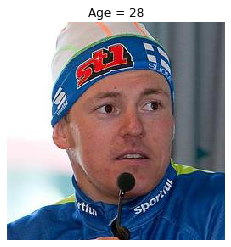

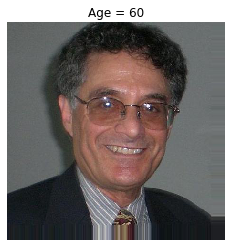

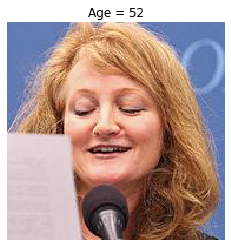

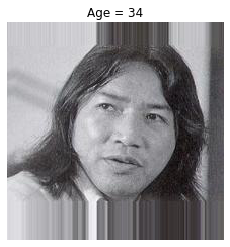

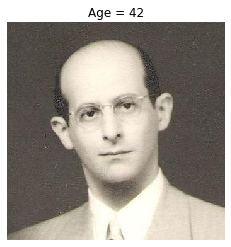

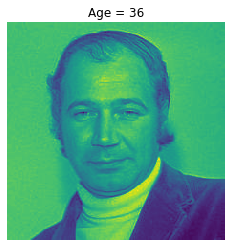

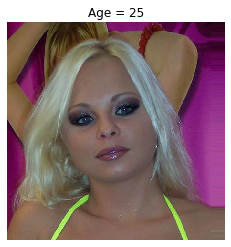

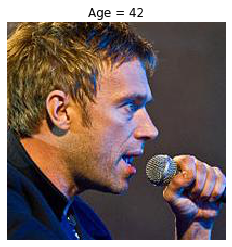

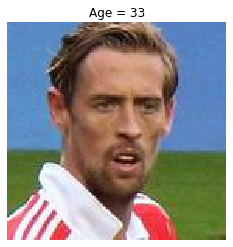

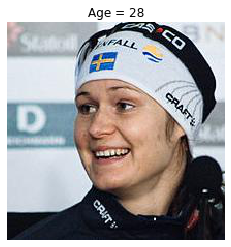

In [22]:
LIMIT = 10  # Viewing the first ten images
for index, row in islice(df.iterrows(), LIMIT): 
    imShow(row) 

In [23]:
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.utils import shuffle

In [24]:
df.shape

(11442, 3)

# How to extract actual pixel data from the images?

In [25]:
from tensorflow.keras.preprocessing import image
target_size = (224, 224)
 
def getImagePixels(image_path,db='wiki'):
    img = image.load_img(f'{db}_crop/{image_path[0]}', grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x
 
df['pixels'] = df['full_path'].apply(getImagePixels)

In [26]:
df.pixels[0]

array([255., 255., 255., ...,  27.,  78., 143.], dtype=float32)

In [28]:
classes = 101 #0 to 100
target = df['age'].values
target_classes = to_categorical(target, classes)
 
features = []
 
for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3) #input image for VGG Face model

# Time for Train-Test Split

In [29]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.3)

In [31]:
train_x.shape

(8009, 224, 224, 3)

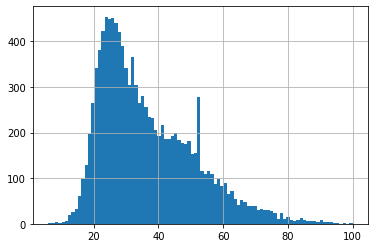

In [32]:
histogram_age = df['age'].hist(bins=df['age'].nunique())
histogram_age

# Let’s construct the VGG Face model in Keras

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, BatchNormalization, UpSampling2D, ZeroPadding2D, Conv2DTranspose, Flatten, MaxPooling2D, AveragePooling2D, Convolution2D

In [34]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

W0529 23:21:27.731514 12012 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
model.load_weights('vgg_face_weights.h5')

# Custom layer

In [36]:
from tensorflow.keras.models import Model

for layer in model.layers[:-7]:
    layer.trainable = False
    
base_model_output = Sequential()
base_model_output = Conv2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

# Training

In [38]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

age_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='age_model.hdf5'
, monitor = "val_loss", verbose=1, save_best_only=True, mode = 'auto')

scores = []
epochs = 250; batch_size = 256

for i in range(epochs):
    ix_train = np.random.choice(train_x.shape[0], size=batch_size)
    score = age_model.fit(train_x[ix_train], train_y[ix_train],epochs=1, validation_data=(test_x, test_y), \
                          callbacks=[checkpointer])
    scores.append(score)


Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 14s - loss: 16.0301 - acc: 0.0089
Epoch 00001: val_loss improved from inf to 11.75238, saving model to age_model.hdf5
256/256 [==============================] - 808s 3s/sample - loss: 16.2597 - acc: 0.0195 - val_loss: 11.7524 - val_acc: 0.0163
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 20s - loss: 11.7233 - acc: 0.0000e+00
Epoch 00001: val_loss improved from 11.75238 to 4.61507, saving model to age_model.hdf5
256/256 [==============================] - 1218s 5s/sample - loss: 11.2049 - acc: 0.0039 - val_loss: 4.6151 - val_acc: 0.0379
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 20s - loss: 5.8719 - acc: 0.0268
Epoch 00001: val_loss improved from 4.61507 to 4.60454, saving model to age_model.hdf5
256/256 [==============================] - 1162s 5s/sample - loss: 5.7893 - acc: 0.0234 - val_loss:

256/256 [==============================] - 744s 3s/sample - loss: 4.4866 - acc: 0.0273 - val_loss: 4.4159 - val_acc: 0.0449
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 15s - loss: 4.4206 - acc: 0.0357
Epoch 00001: val_loss improved from 4.41586 to 4.41238, saving model to age_model.hdf5
256/256 [==============================] - 826s 3s/sample - loss: 4.4178 - acc: 0.0312 - val_loss: 4.4124 - val_acc: 0.0449
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 19s - loss: 4.5754 - acc: 0.0402
Epoch 00001: val_loss improved from 4.41238 to 4.40898, saving model to age_model.hdf5
256/256 [==============================] - 851s 3s/sample - loss: 4.5580 - acc: 0.0430 - val_loss: 4.4090 - val_acc: 0.0449
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 16s - loss: 4.4478 - acc: 0.0536
Epoch 00001: val_loss improved from 4.40898 to 4.40563, saving model t

Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 16s - loss: 4.4972 - acc: 0.0402
Epoch 00001: val_loss improved from 4.33867 to 4.33577, saving model to age_model.hdf5
256/256 [==============================] - 1540s 6s/sample - loss: 4.4726 - acc: 0.0352 - val_loss: 4.3358 - val_acc: 0.0449
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 35s - loss: 4.5530 - acc: 0.0179 
Epoch 00001: val_loss did not improve from 4.33577
256/256 [==============================] - 1064s 4s/sample - loss: 4.5367 - acc: 0.0195 - val_loss: 4.3447 - val_acc: 0.0393
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 16s - loss: 4.5140 - acc: 0.0223
Epoch 00001: val_loss improved from 4.33577 to 4.32981, saving model to age_model.hdf5
256/256 [==============================] - 1166s 5s/sample - loss: 4.4940 - acc: 0.0195 - val_loss: 4.3298 - val_acc: 0.0449
Train on 256 sa

256/256 [==============================] - 898s 4s/sample - loss: 4.2545 - acc: 0.0078 - val_loss: 4.2717 - val_acc: 0.0373
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 17s - loss: 4.4051 - acc: 0.0357
Epoch 00001: val_loss improved from 4.27173 to 4.26929, saving model to age_model.hdf5
256/256 [==============================] - 797s 3s/sample - loss: 4.3852 - acc: 0.0352 - val_loss: 4.2693 - val_acc: 0.0411
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 15s - loss: 4.3358 - acc: 0.0357
Epoch 00001: val_loss improved from 4.26929 to 4.26696, saving model to age_model.hdf5
256/256 [==============================] - 819s 3s/sample - loss: 4.3276 - acc: 0.0391 - val_loss: 4.2670 - val_acc: 0.0411
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 18s - loss: 4.2824 - acc: 0.0268
Epoch 00001: val_loss improved from 4.26696 to 4.26460, saving model t

Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 18s - loss: 4.5546 - acc: 0.0134
Epoch 00001: val_loss improved from 4.21912 to 4.21710, saving model to age_model.hdf5
256/256 [==============================] - 803s 3s/sample - loss: 4.5131 - acc: 0.0234 - val_loss: 4.2171 - val_acc: 0.0373
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 16s - loss: 4.2022 - acc: 0.0312
Epoch 00001: val_loss improved from 4.21710 to 4.21508, saving model to age_model.hdf5
256/256 [==============================] - 890s 3s/sample - loss: 4.2045 - acc: 0.0312 - val_loss: 4.2151 - val_acc: 0.0373
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 15s - loss: 4.2260 - acc: 0.0402
Epoch 00001: val_loss improved from 4.21508 to 4.21303, saving model to age_model.hdf5
256/256 [==============================] - 865s 3s/sample - loss: 4.2337 - acc: 0.0352 - val_loss: 4.2130 -

224/256 [=========================>....] - ETA: 18s - loss: 4.4748 - acc: 0.0446
Epoch 00001: val_loss improved from 4.13971 to 4.13848, saving model to age_model.hdf5
256/256 [==============================] - 1077s 4s/sample - loss: 4.4344 - acc: 0.0469 - val_loss: 4.1385 - val_acc: 0.0382
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 19s - loss: 4.1358 - acc: 0.0536
Epoch 00001: val_loss improved from 4.13848 to 4.13701, saving model to age_model.hdf5
256/256 [==============================] - 1038s 4s/sample - loss: 4.1257 - acc: 0.0547 - val_loss: 4.1370 - val_acc: 0.0370
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 19s - loss: 4.2719 - acc: 0.0402
Epoch 00001: val_loss improved from 4.13701 to 4.13581, saving model to age_model.hdf5
256/256 [==============================] - 847s 3s/sample - loss: 4.2732 - acc: 0.0391 - val_loss: 4.1358 - val_acc: 0.0382
Train on 256 samples, valida

256/256 [==============================] - 895s 3s/sample - loss: 4.1813 - acc: 0.0430 - val_loss: 4.1096 - val_acc: 0.0382
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 15s - loss: 4.1091 - acc: 0.0714
Epoch 00001: val_loss improved from 4.10962 to 4.10852, saving model to age_model.hdf5
256/256 [==============================] - 769s 3s/sample - loss: 4.1187 - acc: 0.0664 - val_loss: 4.1085 - val_acc: 0.0382
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 18s - loss: 4.1966 - acc: 0.0357
Epoch 00001: val_loss improved from 4.10852 to 4.10743, saving model to age_model.hdf5
256/256 [==============================] - 847s 3s/sample - loss: 4.1962 - acc: 0.0312 - val_loss: 4.1074 - val_acc: 0.0382
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 14s - loss: 4.1755 - acc: 0.0312
Epoch 00001: val_loss improved from 4.10743 to 4.10640, saving model t

Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 16s - loss: 4.1123 - acc: 0.0179
Epoch 00001: val_loss improved from 4.08516 to 4.08427, saving model to age_model.hdf5
256/256 [==============================] - 792s 3s/sample - loss: 4.1207 - acc: 0.0195 - val_loss: 4.0843 - val_acc: 0.0382
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 16s - loss: 4.0597 - acc: 0.0357
Epoch 00001: val_loss improved from 4.08427 to 4.08333, saving model to age_model.hdf5
256/256 [==============================] - 884s 3s/sample - loss: 4.0727 - acc: 0.0391 - val_loss: 4.0833 - val_acc: 0.0382
Train on 256 samples, validate on 3433 samples
224/256 [=========================>....] - ETA: 16s - loss: 4.0644 - acc: 0.0357
Epoch 00001: val_loss improved from 4.08333 to 4.08238, saving model to age_model.hdf5
256/256 [==============================] - 807s 3s/sample - loss: 4.0494 - acc: 0.0352 - val_loss: 4.0824 -

# Model Evaluation

age estimation is a regression and not a classification problem, as age is continuous rather than a set of discrete classes. For regression we replace the last layer with only 1 output neuron and employ an Euclidean loss function.

Unfortunately training a CNN directly for regression is relatively unstable as outliers cause a large error term.
This results in very large gradients which makes it difficult for the network to converge and leads to unstable
predictions.

Therefore we have phrased this prediction problem as a classification problem where the classes are age values ranging from 1 to 100.

Researchers have suggested that we train the CNN for classification and at test time we compute the expected value over the softmax normalized output probabilities of the |Y| neurons.


E(O) = $\sum\limits_{i=1}^{|Y|}$yi·oi

where O = {1, 2, ..., |Y |} is the |Y |-dimensional output layer and oi ∈ O is the softmax-normalized output probability of neuron i. 

In [39]:
predictions = age_model.predict(test_x)
 
output_indexes = np.array([i for i in range(0, 101)])
model_predictions = np.sum(predictions * output_indexes, axis = 1)

Researchers have used MAE as an error metric for all experiments and report them in years. This is the average of the absolute error between the predicted age and the ground truth age.

In [41]:
mae = 0
 
for i in range(0 ,model_predictions.shape[0]):
    prediction = int(model_predictions[i])
    actual = np.argmax(test_y[i])
    abs_error = abs(prediction - actual)
    mae +=abs_error

mae /=model_predictions.shape[0]
 
print("mae: ",mae)

mae:  0.002330323332362365


# Prediction

In [54]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    return test_img

In [63]:
picture = "ChrisPratt.jpg"
prediction = age_model.predict(loadImage(picture))
print(prediction)

[[0.0026992  0.00269871 0.00270394 0.00269016 0.00264678 0.00272416
  0.0029563  0.00282289 0.0030119  0.00320941 0.00289101 0.0030722
  0.00334309 0.00421453 0.00421972 0.00523625 0.00718887 0.00921055
  0.01195665 0.01631257 0.01940767 0.02423505 0.02552306 0.02752176
  0.02912022 0.02714374 0.0266771  0.02616715 0.02563828 0.02541406
  0.02285837 0.02249684 0.02410995 0.02197759 0.01855287 0.02050553
  0.01810986 0.01919478 0.01768649 0.01476086 0.01494292 0.01717254
  0.0138753  0.01535718 0.01478624 0.01528586 0.01574224 0.01399703
  0.01438686 0.01466583 0.01299354 0.01294146 0.01300931 0.01222744
  0.01127774 0.01064645 0.01088042 0.0098953  0.00884435 0.00935807
  0.00883755 0.0087499  0.00731869 0.00757466 0.00645001 0.00603148
  0.00606306 0.00590137 0.00588482 0.00601788 0.00530054 0.00578562
  0.00504579 0.00546371 0.00525933 0.00424374 0.00451393 0.00369189
  0.00437051 0.00404379 0.00419504 0.00368646 0.00348265 0.003332
  0.00368435 0.00383946 0.00364406 0.00341365 0.003

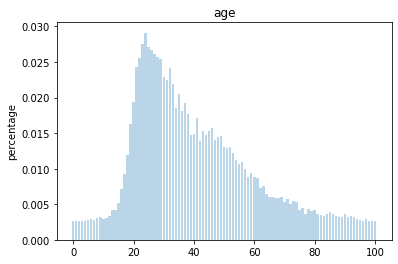

In [64]:
plt.bar(np.arange(101), prediction[0], align='center', alpha=0.3)
plt.ylabel('percentage')
plt.title('age')
plt.show();

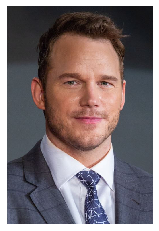

most dominant age class : 24
Predicted age:  41


In [68]:
img = image.load_img(picture)
plt.imshow(img)
plt.axis("off")
plt.show()
 
print("most dominant age class :",np.argmax(prediction))
 
Predicted_age = np.round(np.sum(prediction * output_indexes, axis = 1))
print("Predicted age: ", int(Predicted_age[0]))
